## Online Shopper Intention Classification Example

The HTML reports for this notebook are available at the below location:  
https://drive.google.com/drive/u/0/folders/1s1WlbsNF4WV9yX3DGTOSxHIPnJm6sw7B

## Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import os
import sys

sys.path.append(os.path.join(os.getcwd(),"../.." ))

import eda
import model_gen
import model_eval
from utils import load_yml
import feature_selection as fs
import data_processing as dp

file_path = 'D:/TigerML/code_templates-classification-scripts/case_examples/shopper-intention/config.yml'

## Config file

### dataset : https://www.kaggle.com/roshansharma/online-shoppers-intention
### yml file : Consists of hard coded configuration such as: 

###### dataset_path - local directory path with data
###### estimator_path - local directory with estimators (models and grid search parameters)
###### target_column - binary dependent variable column name in dataset.
###### train_ratio - train and testing dataset split ratio for model building.
###### drop_cols - columns / variables to remove from datatset.
###### numeric_impute and categorical_impute
###### fs - feature selection type (recursion - sklearn feature selection / fs - mlxtend feature selection)
###### fs_params - parameters related to feature selection model 

In [2]:
config_file = load_yml(file_path)
print(config_file)

{'dataset_path': 'D:/TigerML/code_templates-classification-scripts/online_shoppers_intention.csv', 'estimator_config_path': 'D:/TigerML/code_templates-classification-scripts/case_examples/shopper-intention/estimators.yml', 'target_column': 'Revenue', 'output_path': 'D:/TigerML/code_templates-classification-scripts/case_examples/shopper-intention/model_output.csv', 'train_ratio': 0.8, 'seed': 13, 'drop_cols': [], 'numeric_impute': 'mean', 'categorical_impute': 'mode', 'fs': 'recursion', 'feature_selection': {'regularization': {'estimator': 'sklearn.linear_model.Ridge', 'estimator_params': {'alpha': 0.5}}, 'recursion': {'estimator': 'sklearn.linear_model.Ridge', 'estimator_params': {'alpha': 0.5}, 'fs_params': {'forward': False, 'verbose': False, 'k_features': 'best'}}}}


## Data Processing

In [3]:
df_data = dp.load_dataset(config_file['dataset_path'],config_file['target_column'],config_file['drop_cols'])

### Health Analysis

#### We will convert the pandas dataframe to Analyser class of TigerML for further analysis

In [4]:
an = eda.Analyser(data = df_data)

##### Glimpse through features and datatypes

In [5]:
an.variable_summary() 

Started running variable_summary
Finished running variable_summary
Time taken to run variable_summary is 0 seconds


In [6]:
df_data.revenue.value_counts(normalize = True)._data

0    0.845255
1    0.154745
Name: revenue, dtype: float64

###### Continuous variables - Administrative, Administrative Duration, Informational, Informational Duration, Product Related, Product Related Duration, BounceRates , ExitRates and  PageValues.
##### Although OperatingSystems, Browser, Region, TrafficType are int types they are categorical variables. we can convert them to str type to see joint plots with Revenue (DV). 
###### Categorical variables - Month, Visitor Type
###### Revenue is the target variable with event rate of 15%

In [7]:
lst = ['browser', 'region', 'traffictype', 'operatingsystems','weekend']
df_data[lst] = df_data[lst].astype(str)

##### Exploring missing values in the dataset

In [8]:
an = eda.Analyser(data = df_data)
an.missing_value_summary()

Started running missing_value_summary
Finished running missing_value_summary
Time taken to run missing_value_summary is 0 seconds


index            Variable Name  No of Missing  Per of Missing
0      0           administrative             14        0.113544
1      1  administrative_duration             14        0.113544
2      2            informational             14        0.113544
3      3   informational_duration             14        0.113544
4      4           productrelated             14        0.113544
5      5  productrelated_duration             14        0.113544
6      6              bouncerates             14        0.113544
7      7                exitrates             14        0.113544

In [9]:
df_data[df_data.isnull().any(axis=1)]

#### Looking at the above we observe that missing values for columns are for the same set of rows. Instead of imputing these rows synthetically with mean/median removing rows can be a better choice, in addition to it, we know the percentage of missing values are 0.11%  

In [10]:
df_data.dropna(inplace = True)

### Numeric variable summary and outliers

In [11]:
an.numeric_summary()

Started running numeric_summary
Started running variable_summary
Finished running variable_summary
Time taken to run variable_summary is 0 seconds
Finished running numeric_summary
Time taken to run numeric_summary is 0 seconds


In [12]:
num_cols = set(df_data._get_numeric_data().columns) - set(['revenue','specialday'])

df_outliers = an.get_outliers_df().reset_index()
df_outliers[df_outliers['feature'].isin(num_cols)]

feature  < (mean-3*std)  > (mean+3*std)  \
0           administrative               0             213   
1  administrative_duration               0             232   
2              bouncerates               0             705   
3                exitrates               0             709   
4            informational               0             260   
5   informational_duration               0             230   
6               pagevalues               0             258   
7           productrelated               0             236   
8  productrelated_duration               0             219   

   < (1stQ - 1.5 * IQR)  > (3rdQ + 1.5 * IQR)  -inf  +inf  
0                     0                   404     0     0  
1                     0                  1167     0     0  
2                     0                  1548     0     0  
3                     0                  1094     0     0  
4                     0                  2630     0     0  
5                    33                  2404     0     0  
6                     0                  2730     0     0  
7                     0                   987     0     0  
8                     0                   960     0     0

#### we observe that there are several values above and below the lower(1st - 1.5 IQR)  and upper (3rd + 1.5 IQR)  fence. 

In [13]:
config_file

{'dataset_path': 'D:/TigerML/code_templates-classification-scripts/online_shoppers_intention.csv',
 'estimator_config_path': 'D:/TigerML/code_templates-classification-scripts/case_examples/shopper-intention/estimators.yml',
 'target_column': 'Revenue',
 'output_path': 'D:/TigerML/code_templates-classification-scripts/case_examples/shopper-intention/model_output.csv',
 'train_ratio': 0.8,
 'seed': 13,
 'drop_cols': [],
 'numeric_impute': 'mean',
 'categorical_impute': 'mode',
 'fs': 'recursion',
 'feature_selection': {'regularization': {'estimator': 'sklearn.linear_model.Ridge',
   'estimator_params': {'alpha': 0.5}},
  'recursion': {'estimator': 'sklearn.linear_model.Ridge',
   'estimator_params': {'alpha': 0.5},
   'fs_params': {'forward': False, 'verbose': False, 'k_features': 'best'}}}}

In [14]:
config_file.update({'target_column': config_file['target_column'].lower()})

## EDA 

### Univariate Analysis 

FROM REPORT

VisitorType - 85% of visitors are Returning visitors

Month - Month of May has the maximum number of visitors (27%) followed by November and March.

BrowserType and OperatingSystem - 64% of visitors are using browser type 2 and 53% are using OS 2.

Started running health_analysis
Started running data_health
Started running duplicate_columns
processing set of - ['operatingsystems', 'browser', 'region', 'traffictype']
Finished running duplicate_columns
Time taken to run duplicate_columns is 0 seconds
Finished running data_health
Time taken to run data_health is 0 seconds
Started running missing_plot
Finished running missing_plot
Time taken to run missing_plot is 0 seconds
Started running missing_value_summary
Finished running missing_value_summary
Time taken to run missing_value_summary is 0 seconds
Finished running health_analysis
Time taken to run health_analysis is 0 seconds
Started running preprocess_data
Cleaning data
No missing values
No Infinity values
Have 1 boolean variables. Converting False to 0 and True to 1
Encoding categorical variables with default settings which will not be ideal. Processing these variables manually is highly recommended.
operatingsystems has levels with less than 246 (2.0%) values. Target encoding 

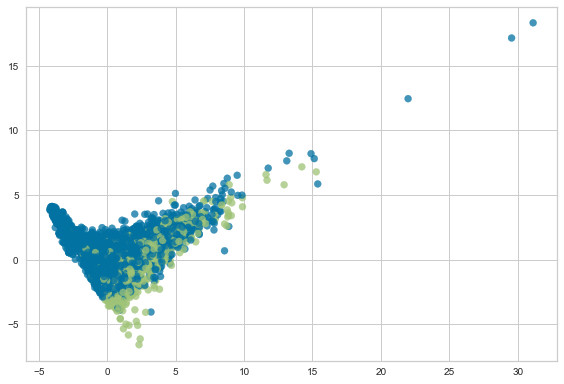

In [15]:
eda.perform_eda(df_data, config_file['target_column'])

### Bivariate Analysis

#### Joint Plots

In [16]:
joint_object = eda.JointPlot(df_data)
joint_plots = joint_object.get_plots(x_vars = ['month','visitortype','browser', 'region','weekend'], 
                                     y_vars = config_file['target_column']) 

In [17]:
joint_plots['visitortype'][config_file['target_column']]

:Bars   [visitortype,Variable]   (value)

#### New visitors tend to generate more Revenue

In [18]:
joint_plots['month'][config_file['target_column']]

:Bars   [month,Variable]   (value)

#### Although the number of visitors in November are lesser compared the May, the revenue rate is higher for november.

In [19]:
joint_plots['weekend'][config_file['target_column']]

:Bars   [weekend,Variable]   (value)

#### More Revenue is generated during weekends in comparison with weekdays

In [20]:
joint_plots['region'][config_file['target_column']]

:Bars   [region,Variable]   (value)

#### Revenue rate across all regions are between 13-16%

#### Correlation Matrix between independent continuous variables

In [21]:
num_cols = df_data._get_numeric_data().columns

x = an.correlation_table()
x[(x['Variable 1'].isin(num_cols)) & (x['Abs Coer Coef']>0.7)]

Started running correlation_table
Finished running correlation_table
Time taken to run correlation_table is 0 seconds


Variable 1               Variable 2  Coer Coef  Abs Coer Coef
0     bouncerates                exitrates   0.913436       0.913436
1  productrelated  productrelated_duration   0.860868       0.860868

#### We observe multicollinear features

#### Overlapping histograms

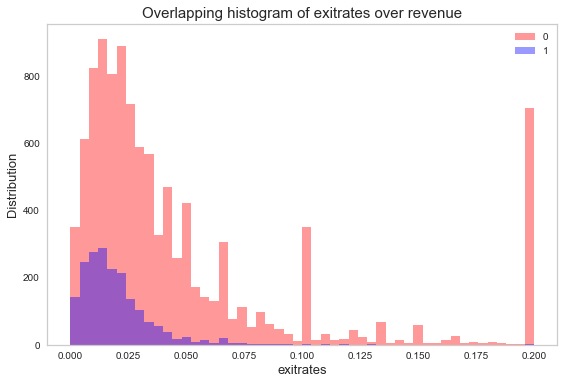

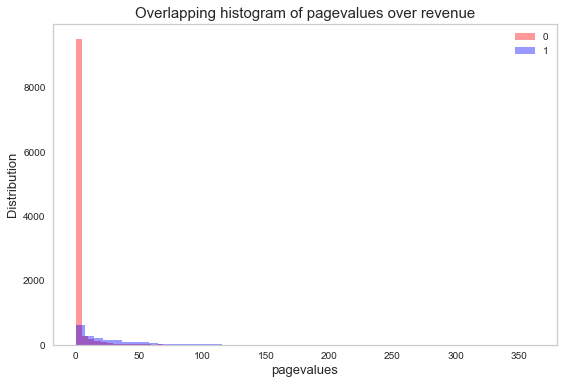

In [22]:
for i in ['exitrates','pagevalues']:
    eda.overlapping_histograms(df_data,i, config_file['target_column'])

#### With high exit rates it is observed that revenue rate is zero.

#### Generating health report as HTML 

In [23]:
an.health_analysis(save_as = '.html')

Started running health_analysis
Started running data_health
Started running duplicate_columns
processing set of - ['operatingsystems', 'browser', 'region', 'traffictype']
Finished running duplicate_columns
Time taken to run duplicate_columns is 0 seconds
Finished running data_health
Time taken to run data_health is 0 seconds
Started running missing_plot
Finished running missing_plot
Time taken to run missing_plot is 0 seconds
Started running missing_value_summary
Finished running missing_value_summary
Time taken to run missing_value_summary is 0 seconds
Finished running health_analysis
Time taken to run health_analysis is 1 seconds


{'health_plot': :Layout
    .Bars.I   :Bars   [index,Variable]   (value)
    .Bars.II  :Bars   [index,Variable]   (value)
    .Bars.III :Bars   [index,Variable]   (value)
    .Bars.IV  :Bars   [index,Variable]   (value),
 'missing_plot': :Bars   [index]   (0),
 'missing_value_summary': 'No Missing Values',
 'duplicate_columns': 'No duplicate variables',
 'outliers_in_features':                          < (mean-3*std)  > (mean+3*std)  < (1stQ - 1.5 * IQR)  \
 feature                                                                         
 administrative                        0             213                     0   
 administrative_duration               0             232                     0   
 bouncerates                           0             705                     0   
 exitrates                             0             709                     0   
 informational                         0             260                     0   
 informational_duration                0      

#### Feature Analysis

In [24]:
an.feature_analysis(save_as=".html")

Started running feature_analysis
Started running numeric_summary
Started running variable_summary
Finished running variable_summary
Time taken to run variable_summary is 0 seconds
Finished running numeric_summary
Time taken to run numeric_summary is 0 seconds
Started running non_numeric_summary
Started running variable_summary
Finished running variable_summary
Time taken to run variable_summary is 0 seconds
Finished running non_numeric_summary
Time taken to run non_numeric_summary is 0 seconds
Started running density_plots
Finished running density_plots
Time taken to run density_plots is 0 seconds
Started running percentile_plots
Finished running percentile_plots
Time taken to run percentile_plots is 0 seconds
Started running non_numeric_frequency_plot
Finished running non_numeric_frequency_plot
Time taken to run non_numeric_frequency_plot is 0 seconds
Started running feature_normality
Finished running feature_normality
Time taken to run feature_normality is 0 seconds
Finished running 

{'summary_stats': {'numeric_variables': [<tigerml.dataframe.dataframe.DataFrame at 0x19b00dbf5e0>],
  'non_numeric_variables': [<tigerml.dataframe.dataframe.DataFrame at 0x19b7c11af40>]},
 'distributions': {'numeric_variables': {'administrative': [:Layout
       .Distribution.I :Distribution   [administrative]   (Density)
       .Table.I        :Table   [count,mean,std,min,25%,50%,75%,max],
    :Layout
       .Bars.Administrative :Bars   [index]   (administrative)
       .Table.I             :Table   [min,0.2%,0.4%,0.6%,0.8%,1%]
       .Table.II            :Table   [99%,99.2%,99.4%,99.6%,99.8%]],
   'administrative_duration': [:Layout
       .Distribution.I :Distribution   [administrative_duration]   (Density)
       .Table.I        :Table   [count,mean,std,min,25%,50%,75%,max],
    :Layout
       .Bars.Administrative_duration :Bars   [index]   (administrative_duration)
       .Table.I                      :Table   [min,0.2%,0.4%,0.6%,0.8%,1%]
       .Table.II                     :Tabl

#### Key drivers

Started running preprocess_data
Cleaning data
No missing values
No Infinity values
Have 1 boolean variables. Converting False to 0 and True to 1
Encoding categorical variables with default settings which will not be ideal. Processing these variables manually is highly recommended.
operatingsystems has levels with less than 246 (2.0%) values. Target encoding in such cases is not recommended.
browser has levels with less than 246 (2.0%) values. Target encoding in such cases is not recommended.
visitortype has levels with less than 246 (2.0%) values. Target encoding in such cases is not recommended.
traffictype has levels with less than 246 (2.0%) values. Target encoding in such cases is not recommended.
month has levels with less than 246 (2.0%) values. Target encoding in such cases is not recommended.
Finished running preprocess_data
Time taken to run preprocess_data is 0 seconds
Started running get_feature_scores
Finished running get_feature_scores
Time taken to run get_feature_scores 

{'revenue': {'feature_scores': {'feature_correlation': :Bars   [index]   (Pearson_correlation_with_Target)},
  'feature_importances': {'from_model': :Bars   [index]   (importance)},
  'pca_analysis': {'pca_projection': :DynamicMap   []
      :RGB   [PC1,PC2]   (R,G,B,A),
   'correlation_with_dimension_2 (Y)': :Bars   [index]   (Pearson_correlation_with_Target),
   'correlation_with_dimension_1 (X)': :Bars   [index]   (Pearson_correlation_with_Target)}}}

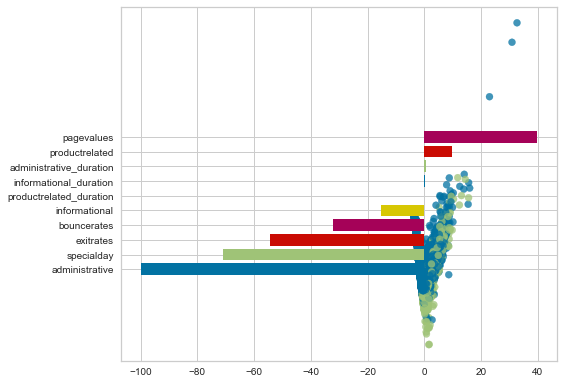

In [25]:
an = eda.Analyser(data = df_data)
an.key_drivers(save_as=".html", y = config_file['target_column'])

## Model Generation and Data Preparation 

In [26]:
## Dropping multicollinear columns
df_data.drop(['bouncerates','productrelated'], axis = 1, inplace = True)

## Object to int type (No variance in Revenue rate from joint plot)
lst = ['browser', 'region', 'traffictype', 'operatingsystems']
df_data[lst] = df_data[lst].astype(str).astype(int)

#### Categorical encoding

In [27]:
df_transform = df_data.copy()

## Three types of encodings are available 
## One Hot
## Label Encode 
## Target Encoding

## Target encoding
df_transform['month'] = dp.Encoder.targetEncode(feature = df_transform['month'], target = df_transform[config_file['target_column']])[0]
df_transform['visitortype'] = dp.Encoder.targetEncode(feature = df_transform['visitortype'], target = df_transform[config_file['target_column']])[0]

df_transform['weekend'] = dp.Encoder.onehotEncode(feature = df_transform['weekend'], target = df_transform[config_file['target_column']]).iloc[:,1]
df_transform.head()

### Train - Test Split

##### Once categorical encoding is done, we apply train test split on the dataset. 
##### Stratify = y (to be added in tigerML)

In [28]:
x_train, x_test, y_train, y_test = dp.prep_data(data = df_transform, dv_name = config_file['target_column'], 
                                             train_size = config_file['train_ratio'], remove_outliers = None, 
                                             random_state = config_file['seed'])

Cleaning data
Dropped 14 rows with missing values.
No Infinity values
Have 2 boolean variables. Converting False to 0 and True to 1
No categorical variables in the data


### Feature selection

In [29]:
features, df_feature_sel_metrics = fs.select_features(x_train, y_train, config_file)

selected features: ['exitrates', 'month', 'operatingsystems', 'pagevalues', 'productrelated_duration', 'region', 'specialday', 'weekend']


In [30]:
df_feature_sel_metrics.head()

feature_names avg_score
8   (exitrates, month, operatingsystems, pagevalue...  0.277417
9   (browser, exitrates, month, operatingsystems, ...    0.2774
10  (browser, exitrates, informational, month, ope...  0.277371
11  (administrative_duration, browser, exitrates, ...  0.277295
7   (exitrates, month, operatingsystems, pagevalue...  0.277284

In [31]:
x_train = x_train[features]
x_test = x_test[features]

## Different Model Comparison

 99%|===================| 198/200 [01:31<00:00]        WARNING:shap:Using 2431 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.




Data is not passed to ShapExplainer since it is an XGBClassifier.


Data is not passed to ShapExplainer since it is an XGBClassifier.


Data is not passed to ShapExplainer since it is an XGBClassifier.



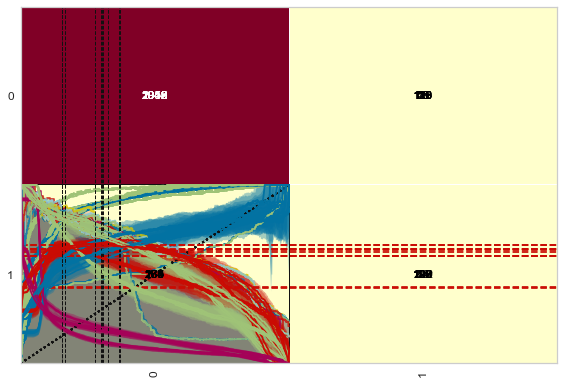

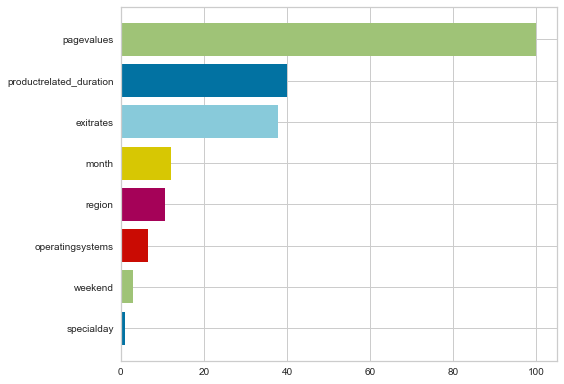

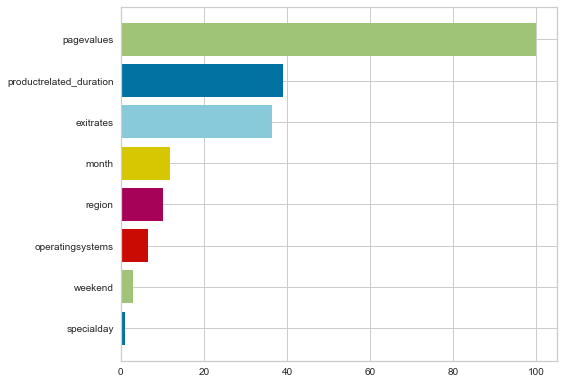

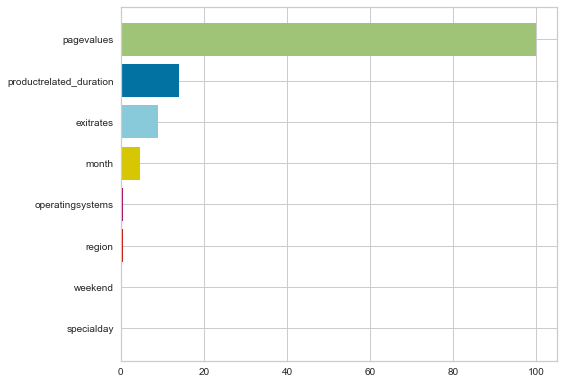

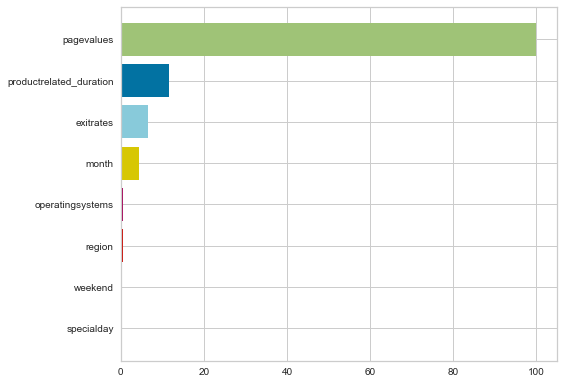

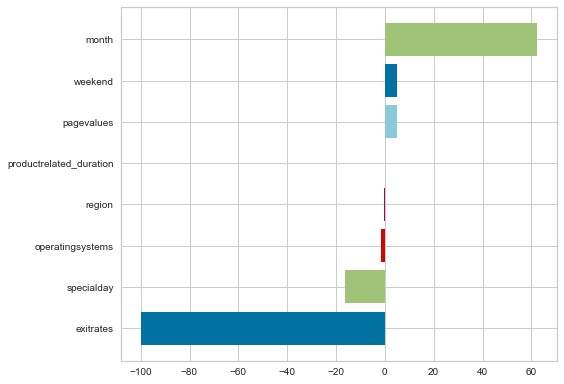

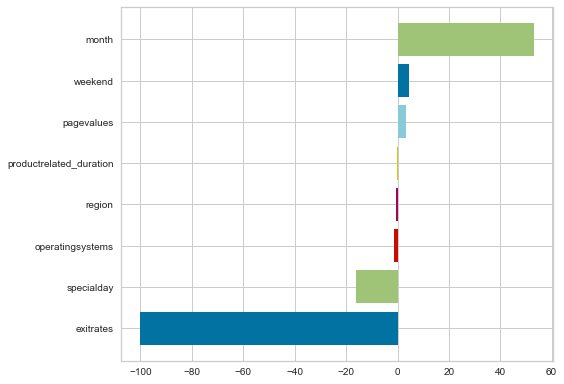

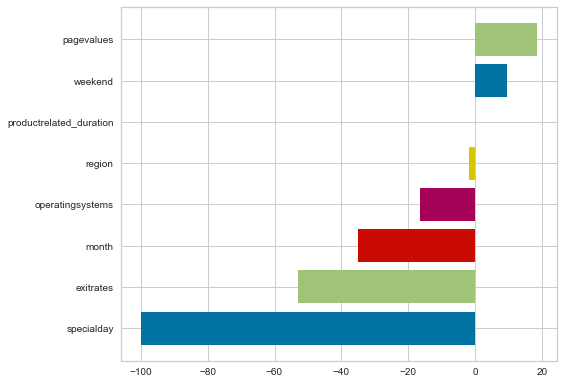

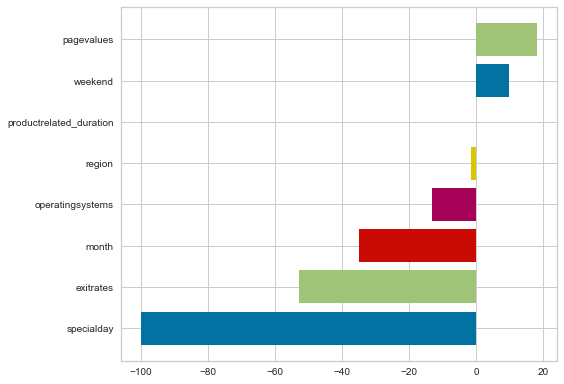

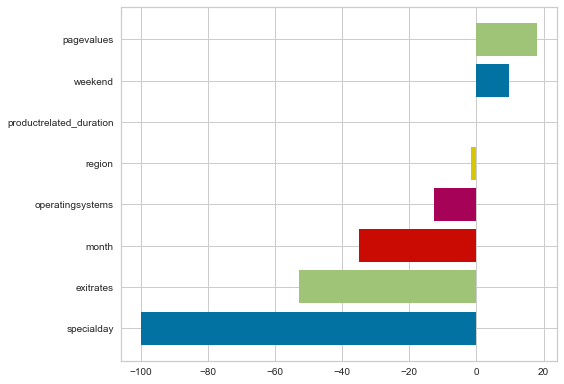

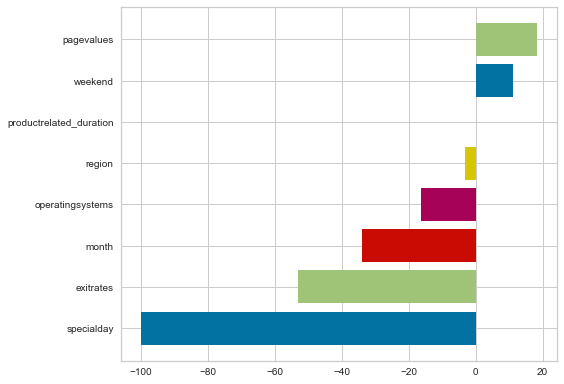

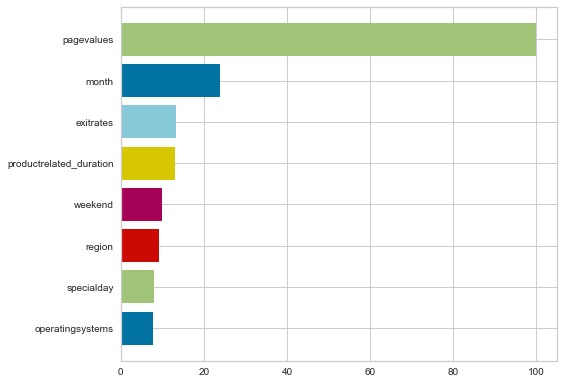

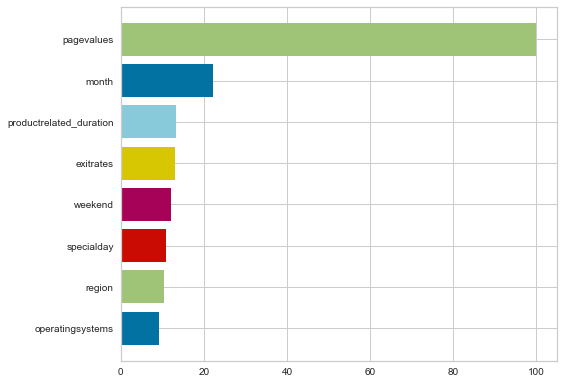

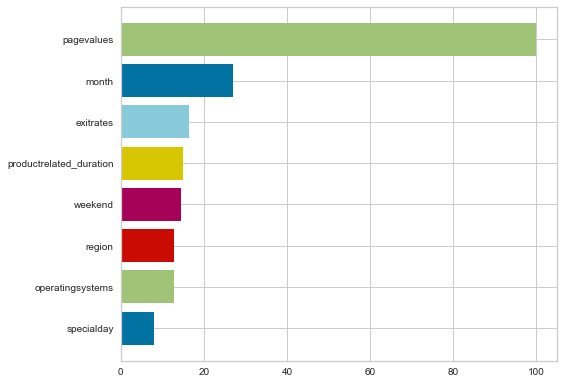

In [32]:
estimator_file= load_yml(config_file['estimator_config_path'])
models=model_gen.list_models_from_config(estimator_file)
rpt=model_eval.ClassificationComparison(models)
rpt.fit(x_train,y_train)
rpt.score(x_test, y_test)
rpt.get_report()

##### Grid search with all types of models in config file with respective parameters. 
##### Best performing model and hyper parameters will be the final result.
##### STEP 1 - model_gen.train_model will run list of models with parameters specified in estimators.yml. 
##### STEP 2 - best_fit - best perfoming model (out of all estimator) with optimized paramters producing highest mean accuracy.  

In [33]:
best_fit = model_gen.train_model(file_path, x_train, y_train)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] max_features=0.7, n_estimators=100 ..............................
[CV]  max_features=0.7, n_estimators=100, score=(train=1.000, test=0.908), total=   1.2s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[CV] max_features=0.7, n_estimators=100 ..............................
[CV]  max_features=0.7, n_estimators=100, score=(train=1.000, test=0.893), total=   1.2s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[CV] max_features=0.7, n_estimators=100 ..............................
[CV]  max_features=0.7, n_estimators=100, score=(train=1.000, test=0.885), total=   1.1s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.6s remaining:    0.0s
[CV] max_features=0.7, n_estimators=100 ..............................
[CV]  max_

[CV] . C=1, penalty=l2, score=(train=0.497, test=0.496), total=   0.6s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    5.2s remaining:    0.0s
[CV] C=1, penalty=l2 .................................................
[CV] . C=1, penalty=l2, score=(train=0.863, test=0.858), total=   0.6s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    5.8s remaining:    0.0s
[CV] C=1, penalty=l2 .................................................
[CV] . C=1, penalty=l2, score=(train=0.880, test=0.879), total=   0.6s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.4s finished
Best estimator : LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
<class 'sklearn.linear_model._logistic.LogisticRegression'>
Fitting 5 folds for each of 

[CV]  max_depth=6, n_estimators=100, score=(train=0.973, test=0.887), total=   0.5s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.6s remaining:    0.0s
[CV] max_depth=7, n_estimators=100 ...................................
[CV]  max_depth=7, n_estimators=100, score=(train=0.981, test=0.898), total=   0.5s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.1s remaining:    0.0s
[CV] max_depth=7, n_estimators=100 ...................................
[CV]  max_depth=7, n_estimators=100, score=(train=0.985, test=0.889), total=   0.6s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    5.7s remaining:    0.0s
[CV] max_depth=7, n_estimators=100 ...................................
[CV]  max_depth=7, n_estimators=100, score=(train=0.983, test=0.881), total=   0.5s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    6.3s remaining:    0.0s
[CV] max_depth=7, n_estimators=100 ...................................
[CV]  max_depth=7, n_estimators=100, score=(train=0.984, tes

## Model Evaluation 

More information on the ClassificationReport is availabe here: https://tigerrepository.github.io/TigerML/build/html/api/model_eval.html#tigerml.model_eval.ClassificationReport

In [34]:
classifier = model_eval.ClassificationReport(best_fit)

##### Fitting best model from gridsearch to the training data.

In [35]:
classifier.fit(x_train, y_train)

##### Scoring on test dataset

In [36]:
classifier.score(x_test, y_test)

In [37]:
classifier.model.predict_proba(x_test)

array([[0.85237372, 0.14762628],
       [0.97888581, 0.02111419],
       [0.99107916, 0.00892084],
       ...,
       [0.49564027, 0.50435973],
       [0.99102604, 0.00897396],
       [0.31028284, 0.68971716]])

:Overlay
   .Curve.Precision          :Curve   [threshold]   (precision)
   .Curve.Recall             :Curve   [threshold]   (recall)
   .Curve.F1_score           :Curve   [threshold]   (f1_score)
   .Curve.Percent_of_Class_1 :Curve   [threshold]   (% of Class 1)

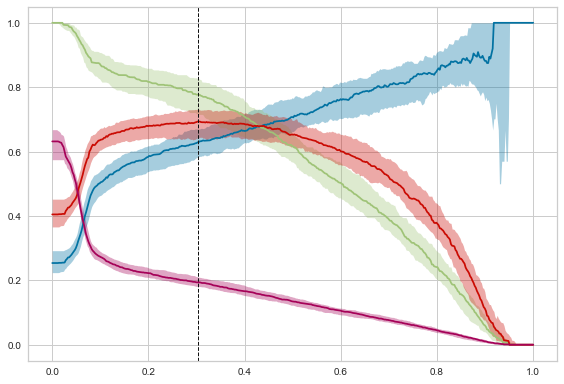

In [38]:
classifier.evaluator.discrimination_threshold()

In [39]:
classifier.model.predict(x_test)

array([0, 0, 0, ..., 1, 0, 1], dtype=int64)

In [40]:
classifier.evaluator.confusion_matrix()

dataset          train                    test            
metric     predicted_0 predicted_1 predicted_0 predicted_1
true_label                                                
0                 7885         292        1949         119
1                  520        1025         162         201

:Curve   [False Positive Rate]   (True Positive Rate)

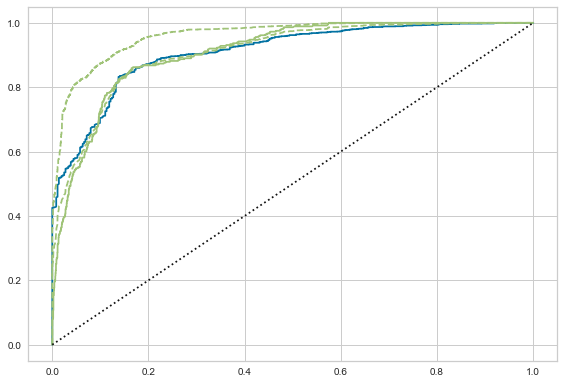

In [41]:
classifier.evaluator.roc_curve()

In [42]:
classifier.get_report()

8 instances are false positives
5 instances are false negatives


### Confusion Matrix component analysis

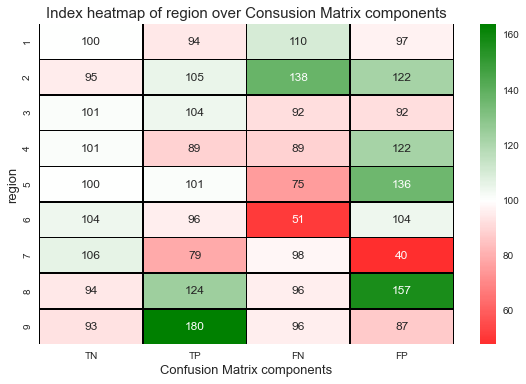

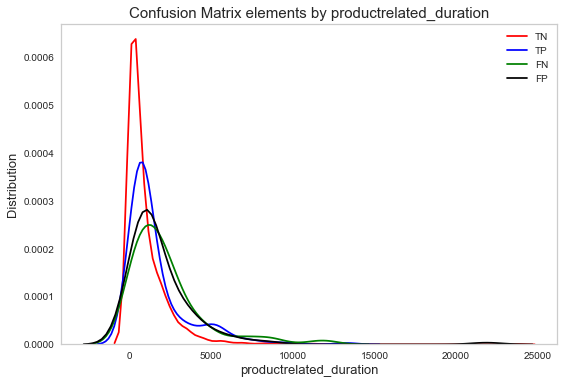

In [43]:
x_eval = x_test.copy()
x_eval['prediction'] = best_fit.predict(x_eval)
x_eval['actuals'] = y_test.reset_index(drop = True).iloc[:,0].values

eda.confusion_matrix_by_feature(x_eval, 'actuals', 'prediction',col_idv='region',categorical=True)
eda.confusion_matrix_by_feature(x_eval, 'actuals', 'prediction',col_idv='productrelated_duration',categorical=False)


The value indicates the index as a ratio of proportion of (TN/TP/FN/FP) in the class and proportion of TN/TP/FN/FP overall. For example, class 0 is 80% of the entire population but it is 20% in FP. So the index is 25.

Here value = 0 means no value presents in that class for that metric. So, 0 is desirable for FN and FP columns. Value = 100 indicate equal representation in both population and TN/TP/FN/FP.

We can tune the features and class where the value is much higer than 100.

For continuous variables, we see that in between certain values the TN/TP value below FP/FN indicating that in those range some tuning is required.